## Gaussian Naive Bayes

#####Nominal: P(lsi|class)=(lsis_in_class + 1)/(lsis_in_class+total_unique_words_in_class)  
#####Continuous: P(lsi|class)=高斯分布機率(帶入平均數與標準差)

In [29]:
#一些需要的function
import numpy as np
def gauss(x,m,s):
    e=-(x-m)**2/(2*(s**2))
    g=1*np.exp(e)/(2*s*np.pi)**0.5
    return g

def remove_punc(sentences):
    import string 
    import re
    delEStr = '['+string.punctuation + u' '+']'
    delCStr = u'''[〔△〇◎◆●✦×→°☆■□◆●○๏••‧㊣℃ˍ╴←↑→．│﹙“—▲►★《》ΟΔΧ╳（）()∫&%﹪￥#@$！?,.…><*{}｢｣\\∼〈〉¬﹄•∼■`"’“×※【】  ’'　、。，‧．·‧‧：︰十；”～‘’′→＠＃＄％︿＆＊｀＝－—─＋｜／＼╲╱╱ ╱╱？『』」「\/]'''
    s=[]
    for sentence in sentences:
        if type(sentence)==unicode:
            sentence=re.sub(delEStr,u'',sentence)
            sentence=re.sub(delCStr,u'',sentence)
            s.append(sentence.encode('utf-8'))
        else:
            sentence=re.sub(delEStr,u'',sentence.decode('utf-8'))
            sentence=re.sub(delCStr,u'',sentence)
            s.append(sentence.encode('utf-8'))
    return s  


def replace_punc(sentences):
    import string 
    import re
    delEStr = '['+string.punctuation + u' '+']'
    delCStr = u'''[〔△〇◎◆●✦×→°☆■□◆●○๏••‧㊣℃ˍ╴←↑→．│﹙“—▲►★《》ΟΔΧ╳（）()∫&%﹪￥#@$！?,.…><*{}｢｣\\∼〈〉¬﹄•∼■`"’“×※【】  ’'　、。，‧．·‧‧：︰十；”～‘’′→＠＃＄％︿＆＊｀＝－—─＋｜／＼╲╱╱ ╱╱？『』」「\/]'''
    s=[]
    for sentence in sentences:
        if type(sentence)==unicode:
            sentence=re.sub(delEStr,u' ',sentence)
            sentence=re.sub(delCStr,u' ',sentence).encode('utf-8')
            sentence=sentence.split(",")
            #s.append(sentence.encode('utf-8'))
            s.append(sentence)
        else:
            sentence=re.sub(delEStr,u' ',sentence.decode('utf-8'))
            sentence=re.sub(delCStr,u' ',sentence).encode('utf-8')
            sentence=sentence.split(",")
            #s.append(sentence.encode('utf-8'))
            s.append(sentence)
    return s[0]

## database version

In [131]:
# 逐行從資料庫提出文章>斷詞
import MySQLdb as mc
import MySQLdb.cursors
import traceback
import jieba
import jieba.analyse
from gensim import corpora, models, similarities
import json
import time 

############# 基本參數設定 ###############
db="ecodaily3"
passwd=""
########################################

jieba.set_dictionary('/usr/local/lib/python2.7/site-packages/jieba/dictbig.txt')
jieba.load_userdict("userdict.txt")
conn=mc.connect(host='localhost',user='root',passwd='',db=db,charset="utf8",cursorclass = MySQLdb.cursors.SSCursor)
cur=conn.cursor()
sql='select content from news2'
cur.execute(sql)
f=open('/Users/jojotenya/Desktop/gensim/test.txt','a')
texts=cur.fetchone()
s=open('/Users/jojotenya/Desktop/gensim/stopword.txt',"r")
stoplist=[]
for stop in s.readlines():
    stoplist.append(stop.strip())
s.close()
stoplist=set(stoplist)
while texts is not None:
    words = jieba.cut(replace_punc([texts[0]])[0], cut_all=False)
    sentence=[]
    for w in words:
        if len(w.strip())<=1:
            continue
        elif w.encode('utf-8') in stoplist:
            #print "stop: ", w
            continue
        else:
            #print "enter: ",w
            sentence.append(w)
    feed=(' '.join(sentence)).encode('utf-8')
    f.write(feed)
    f.write("\n")
    texts=cur.fetchone()

cur.close()
conn.close()
f.close()


#轉換斷詞為純數字vector，生成dictionary詞庫、詞頻統計
#stoplist=[]
dictionary = corpora.Dictionary(line.split() for line in open('/Users/jojotenya/Desktop/gensim/test.txt'))
#stop_ids=[]
#for stopword in stoplist:
#    if stopword.decode('utf-8') in dictionary.token2id:
#        stop_ids.append(stopword.decode('utf-8'))
#once_ids = [tokenid for tokenid, docfreq in dictionary.dfs.iteritems() if docfreq == 1]
#once_ids = []
#dictionary.filter_tokens(stop_ids + once_ids) # remove stop words and words that appear only once
#dictionary.filter_tokens(set(stop_ids))
#dictionary.compactify()
dictionary.save('/Users/jojotenya/Desktop/gensim/test.dict')

class MyCorpus(object):
    def __iter__(self):
        for line in open('/Users/jojotenya/Desktop/gensim/test.txt'):
            yield dictionary.doc2bow(line.split())
corpus = MyCorpus() 
corpora.MmCorpus.serialize('/Users/jojotenya/Desktop/gensim/test.mm', corpus)

'''for c in corpus_to_use:
    print json.dumps(c,ensure_ascii=False)'''

#做tfidf，將斷詞編號依照vector轉換回原本的詞，一同將詞與權重存入database
#Lsi降維，將各topic與權重存入database
#print json.dumps(dictionary.token2id, encoding="utf-8", ensure_ascii=False)
##no update：
#dictionary=corpora.Dictionary.load('/Users/jojotenya/Desktop/test.dict')
#corpus=corpora.MmCorpus('/Users/jojotenya/Desktop/test.dict')
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
t=[]
for doc in corpus_tfidf:
     t.append([[dictionary.token2id.keys()[dictionary.token2id.values().index(d[0])],d[1]] for d in doc])      
lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=10)
lsi.save('/Users/jojotenya/Desktop/gensim/test.lsi')
corpus_lsi = lsi[corpus_tfidf]
l=[]

c=[]
for doc in corpus:
     c.append([d[1] for d in doc])

for i in xrange(0,60):
    for j in xrange(0,len(t[i])):
        t[i][j].append(c[i][j])

for c_lsi in corpus_lsi:
    l.append(c_lsi)       
        
try:
    conn=mc.connect(host='localhost',user='root',passwd='',db=db,charset="utf8",cursorclass = MySQLdb.cursors.SSCursor)
    cur=conn.cursor()
    sql='select newsID from news2'
    cur.execute(sql)
    row=cur.fetchone()

    conn2=mc.connect(host='localhost',user='root',passwd='',db=db,charset="utf8")
    conn2.query('SET autocommit=TRUE;')
    cur2=conn2.cursor()
    conn3=mc.connect(host='localhost',user='root',passwd='',db=db,charset="utf8")
    conn3.query('SET autocommit=TRUE;')
    cur3=conn3.cursor()
    #print json.dumps(t[i],ensure_ascii=False)
    i=0
    while row is not None:    
        for s in t[i]:  
            data=(int(row[0]),s[0],s[1],s[2])
            cur2.execute('insert into keywords(keyid,term,weight,freq) values(%s,%s,%s,%s)',data)
            #conn2.commit()
        for c in l[i]: 
            data=(int(row[0]),c[0],c[1])
            cur3.execute('insert into lsi(lsiid,topic,weight) values(%s,%s,%s)',data)
            #conn3.commit()
        i+=1
        row=cur.fetchone()
except:
    print traceback.format_exc()

finally:
    cur.close()
    conn.close()
    cur2.close()
    conn2.close()
    cur3.close()
    conn3.close()
        

#每個分類的lsi-mu,lsi-sigma
a= time.clock()
conn=mc.connect(host='localhost',user='root',passwd='',
                db=db,charset="utf8",cursorclass = MySQLdb.cursors.SSCursor)
cur=conn.cursor()
cur.execute('select distinct(`class`) from news2')
categories=cur.fetchall()

conn2=mc.connect(host='localhost',user='root',passwd='',
                db=db,charset="utf8",cursorclass = MySQLdb.cursors.SSCursor)
conn2.query('SET autocommit=TRUE;')
cur2=conn2.cursor()

for i in xrange(0,len(categories)):
    cur.execute('select topic,AVG(weight),STD(weight) from lsi where lsiid in \
                (select newsID from news2 where `class` = %s) \
                GROUP BY topic',categories[i])
    result=cur.fetchone()
    while result is not None:
        data=(categories[i],result[0],result[1],result[2])
        cur2.execute('insert into lsiStatistic(`class`,topic,mean,std) value(%s,%s,%s,%s)',data)
        #conn2.commit()
        result=cur.fetchone()

cur.close()
conn.close()
cur2.close()
conn2.close()
print time.clock()-a


Building prefix dict from /usr/local/lib/python2.7/site-packages/jieba/dictbig.txt ...
DEBUG:jieba:Building prefix dict from /usr/local/lib/python2.7/site-packages/jieba/dictbig.txt ...
Loading model from cache /var/folders/pn/qc_lny8n1cv6pt_2tqlg4s6m0000gn/T/jieba.u91a3eae8b085aaf1cd1517c2fdfc2047.cache
DEBUG:jieba:Loading model from cache /var/folders/pn/qc_lny8n1cv6pt_2tqlg4s6m0000gn/T/jieba.u91a3eae8b085aaf1cd1517c2fdfc2047.cache
Loading model cost 1.141 seconds.
DEBUG:jieba:Loading model cost 1.141 seconds.
Prefix dict has been built succesfully.
DEBUG:jieba:Prefix dict has been built succesfully.


0.00278200000002


####分類

In [ ]:
#從資料庫提出要分類的文章的每一個lsi topic，計算其屬於不同類別的gauss機率(可設定低於一定數值以下的歸類為其他)
conn=mc.connect(host='localhost',user='root',passwd='',
                db=db,charset="utf8",cursorclass = MySQLdb.cursors.SSCursor)
cur=conn.cursor()
categories=["國際","兩岸"]   # class which want to reclass
cur.execute('select distinct(`class`) from lsiStatistic')
lsicats=[item[0] for item in cur.fetchall()]
#print json.dumps(lsicats,ensure_ascii=False)
for i in xrange(0,len(categories)):
    cur.execute('select newsID from news2 where `class` = %s;', (categories[i],))
    ID=[item[0] for item in cur.fetchall()]
    conn2=mc.connect(host='localhost',user='root',passwd='',
                    db=db,charset="utf8",cursorclass = MySQLdb.cursors.SSCursor)
    cur2=conn2.cursor()
    conn3=mc.connect(host='localhost',user='root',passwd='',
                    db=db,charset="utf8",cursorclass = MySQLdb.cursors.SSCursor)
    cur3=conn3.cursor()
    conn4=mc.connect(host='localhost',user='root',passwd='',
                    db=db,charset="utf8",cursorclass = MySQLdb.cursors.SSCursor)
    conn4.query('SET autocommit=TRUE;')
    cur4=conn4.cursor()
    for n in ID:
        try:
            print n
            cur2.execute('select weight from lsi where lsiid=%s',(n,))
            forlsicat=[item[0] for item in cur2.fetchall()]  #lsiweight for comparing to lsiStatistic
            print forlsicat
            allgauss={}
            for cat in lsicats:        
                cur3.execute('select mean,std from lsiStatistic where `class` = %s',(cat,))
                inoneclass=cur3.fetchall()
                #print inoneclass
                ini=1
                
                for m in xrange(0,len(inoneclass)):
                    ini=ini*gauss(forlsicat[m],inoneclass[m][0],inoneclass[m][1])
                allgauss[cat]=ini
            print json.dumps(allgauss,ensure_ascii=False)
            reclass=allgauss.keys()[allgauss.values().index(max(allgauss.values()))]
            print reclass
            cur4.execute('update news2 set reclass= %s where newsid =%s',(reclass,n))
            #conn4.commit()
        except:
            pass
    cur2.close()
    conn2.close()
    cur3.close()
    conn3.close()
    cur4.close()
    conn4.close()

cur.close()
conn.close()
#判斷是何種新聞類別後更新類別欄位reclass

####分群

In [ ]:
#將同一類別新聞們分群
import MySQLdb as mc
import MySQLdb.cursors
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.decomposition import PCA
from sklearn.decomposition import RandomizedPCA

conn=mc.connect(host='localhost',user='root',passwd='',db=db,charset="utf8",cursorclass = MySQLdb.cursors.SSCursor)
cur=conn.cursor()
conn2=mc.connect(host='localhost',user='root',passwd='',db=db,charset="utf8",cursorclass = MySQLdb.cursors.SSCursor)
conn2.query('SET autocommit=TRUE;')
cur2=conn2.cursor()
sql='select distinct(reclass) from news2'
cur.execute(sql)
reclass=cur.fetchall()

for re in reclass:
    corpus=[]
    cur.execute('select content from news2 where reclass=%s',(re,))
    texts=cur.fetchone()
    while texts is not None:
        words = jieba.cut(remove_punc([texts[0]])[0], cut_all=False)
        sentence=[]
        for w in words:
            if len(w)==1:
                pass
            else:
                sentence.append(w)
        feed=(' '.join(sentence)).encode('utf-8')
        corpus.append(feed)
        texts=cur.fetchone()
    vectorizer = HashingVectorizer(n_features=2**18) 
    X = vectorizer.fit_transform(corpus)
    transformer = TfidfTransformer()
    tfidf = transformer.fit_transform(X)
    weight = tfidf.toarray()    

    n_cosine_similarities = linear_kernel(tfidf, tfidf)
    from sklearn import cluster
    c = cluster.KMeans(n_cosine_similarities,3)
    #c = cluster.AffinityPropagation(n_cosine_similarities)
    #print c.n_clusters

    import numpy as np
    from sklearn.decomposition import PCA
    from sklearn.decomposition import RandomizedPCA
    pca = PCA(n_components=2)
    pca_data = pca.fit_transform(n_cosine_similarities)

    #a = pca.fit(n_cosine_similarities)
    #print a
    #print pca_data.shape
    param = [{'model':cluster.KMeans(n_clusters=4),
              'title':'KMeans'}]
    param = [{'model':cluster.MiniBatchKMeans(),
              'title':'AffinityPropagation'}]
    c = param[0]['model']
    k_data = c.fit_predict(n_cosine_similarities)
    #k_data = c.predict(n_cosine_similarities)
    cur2.execute('select newsID from news2 where reclass=%s',(re,))
    ID=cur2.fetchall()
    writeback=[]
    for k in k_data:
        writeback.append(re[0]+str(k))
    print json.dumps(writeback,ensure_ascii=False)
    
    for i,j in enumerate(ID):
        cur2.execute('update news2 set cluster= %s where newsid =%s',(re[0]+str(k_data[i]),j))


        
    #之後文字雲依照分類(m個)＋分群(n個)就可以有m*n個變化
    
cur.close()
conn.close()
cur2.close()
conn2.close()

(60,)


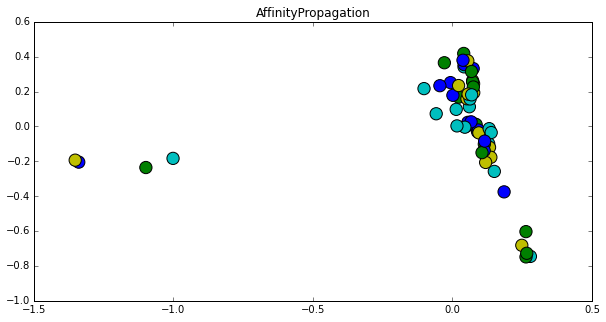

In [115]:
print k_data.shape
#print c.inertia_
#print c.cluster_centers_indices_
%matplotlib inline
from matplotlib import pyplot as plt
fig, axes = plt.subplots(ncols=1, nrows=1,figsize=(10,5))  # figsize: graph size
axes.scatter(pca_data[:,0], pca_data[:,1], c=['rgbyc'[i] for i in k_data ], s=150)
axes.set_title(param[0]['title'])


##non-database vsrsion

In [ ]:
# 逐行從資料庫提出文章>斷詞
import MySQLdb as mc
import MySQLdb.cursors
import traceback
import jieba
import jieba.analyse
from gensim import corpora, models, similarities
import json

conn=mc.connect(host='localhost',user='root',passwd='',db=db,charset="utf8")
cur=conn.cursor()
sql='select content from news2'
cur.execute(sql)
f=open('/Users/jojotenya/Desktop/test.txt','a')
texts=cur.fetchone()
while texts is not None:
    words = jieba.cut(remove_punc([texts[0]])[0], cut_all=False)
    sentence=[]
    for w in words:
        if len(w)==1:
            pass
        else:
            sentence.append(w)
    feed=(' '.join(sentence)).encode('utf-8')
    f.write(feed)
    f.write("\n")
    texts=cur.fetchone()

cur.close()
conn.close()
f.close()


#轉換斷詞為純數字vector，生成dictionary詞庫、詞頻統計
stoplist=[]
dictionary = corpora.Dictionary(line.split() for line in open('/Users/jojotenya/Desktop/gensim/test.txt'))
stop_ids = [dictionary.token2id[stopword] for stopword in stoplist if stopword in dictionary.token2id]
once_ids = [tokenid for tokenid, docfreq in dictionary.dfs.iteritems() if docfreq == 1]
dictionary.filter_tokens(stop_ids + once_ids) # remove stop words and words that appear only once
dictionary.compactify() # remove gaps in id sequence after words that were removed
dictionary.save('/Users/jojotenya/Desktop/gensim/test.dict')

class MyCorpus(object):
    def __iter__(self):
        for line in open('/Users/jojotenya/Desktop/gensim/test.txt'):
            yield dictionary.doc2bow(line.split())
corpus = MyCorpus() 
corpora.MmCorpus.serialize('/Users/jojotenya/Desktop/gensim/test.mm', corpus)

'''for c in corpus_to_use:
    print json.dumps(c,ensure_ascii=False)'''

#做tfidf，將斷詞編號依照vector轉換回原本的詞，一同將詞與權重存入database
#Lsi降維，將各topic與權重存入database
#print json.dumps(dictionary.token2id, encoding="utf-8", ensure_ascii=False)
##no update：
#dictionary=corpora.Dictionary.load('/Users/jojotenya/Desktop/test.dict')
#corpus=corpora.MmCorpus('/Users/jojotenya/Desktop/test.dict')
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=10)
lsi.save('/Users/jojotenya/Desktop/gensim/test.lsi')

        


#Lsi降維，將各topic與權重存入database


#每個分類的lsi-mu

#lsi_list = select * from table_name where class == class_name

#每個分類的lsi-sigma


In [220]:
###分類

In [ ]:
#從資料庫提出要分類的文章的每一個lsi topic，計算其屬於不同類別的gauss機率(可設定低於一定數值以下的歸類為其他)


#判斷是何種新聞類別後更新類別欄位reclass

In [ ]:
###分群

In [ ]:
#將同一類別新聞們分群



#之後文字雲依照分類(m個)＋分群(n個)就可以有m*n個變化

In [399]:
#cosine similarity: tfidf version
corpus = corpora.MmCorpus('/Users/jojotenya/Desktop/gensim/test.mm')
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
lsi=models.LsiModel(corpus_tfidf)
dictionary=corpora.Dictionary.load('/Users/jojotenya/Desktop/gensim/test.dict')
doc = "美國 現任 以及 前總統 卡特 任內 兩位 財政部 助理部長"
vec_bow = dictionary.doc2bow(doc.split())
print (vec_bow)
vec_lsi = lsi[vec_bow] # convert the query to LSI space
index = similarities.MatrixSimilarity(lsi[corpus_tfidf])
index.save('/Users/jojotenya/Desktop/gensim/test.index')
#index = similarities.MatrixSimilarity.load('/Users/jojotenya/Desktop/test.index')
sims = index[vec_lsi]
print sims
from scipy import sparse
print sparse.csr_matrix(sims)
sims = sorted(enumerate(sims), key=lambda item: -item[1])



[(893, 1), (1023, 1), (1843, 1), (3063, 1), (3252, 1), (3297, 1), (3431, 1)]
[  9.34107780e-01  -3.72529030e-09   5.82285598e-02  -7.45058060e-09
   7.45058060e-09   5.30525334e-02  -3.25962901e-09   9.31322575e-09
  -1.49011612e-08   2.23517418e-08   1.25495687e-01   1.29043460e-01
   1.12457119e-01   6.57337755e-02   1.33285999e-01   4.79213111e-02
   7.17962757e-02   0.00000000e+00   0.00000000e+00   7.45058060e-09
   4.10835892e-02   7.45058060e-09   0.00000000e+00   1.30365416e-01
   6.66237026e-02   2.02746108e-01   5.80376536e-02   3.72529030e-09
   8.41709599e-02   2.98023224e-08  -7.45058060e-09   7.45058060e-09
   1.11758709e-08  -7.45058060e-09   0.00000000e+00   1.86264515e-09
  -3.72529030e-09  -2.23517418e-08  -2.23517418e-08  -3.72529030e-09
   3.88897434e-02   7.45058060e-09   1.86264515e-08   1.35881931e-01
   3.72529030e-09   1.49011612e-08   0.00000000e+00   1.11758709e-08
   0.00000000e+00  -7.45058060e-09   0.00000000e+00   6.65191785e-02
  -3.72529030e-09   1.7843

In [422]:
#cosine similarity: no tfidf version
corpus = corpora.MmCorpus('/Users/jojotenya/Desktop/gensim/test.mm')
lsi=models.LsiModel(corpus)  
dictionary=corpora.Dictionary.load('/Users/jojotenya/Desktop/gensim/test.dict')
doc = "美國 現任 以及 前總統 卡特 任內 兩位 財政部 助理部長"
vec_bow = dictionary.doc2bow(doc.split())
vec_lsi = lsi[vec_bow] # convert the query to LSI space
index = similarities.MatrixSimilarity(lsi[corpus])
index.save('/Users/jojotenya/Desktop/gensim/test.index')
#index = similarities.MatrixSimilarity.load('/Users/jojotenya/Desktop/test.index')
sims = index[vec_lsi] 
#print sims, type(sims)
sims = sorted(enumerate(sims), key=lambda item: -item[1])


In [ ]:
from scipy import sparse
corpus = [m for m in MyCorpus()]
#print corpus
print type(np.asarray(corpus))
#print np.asarray(corpus)
#print sparse.csr_matrix(corpus)
'''from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer()
tfidf = transformer.fit_transform(sparse.csr_matrix(np.asarray(corpus)))
weight = tfidf.toarray()   '''

In [ ]:
#cosine similarity: tfidf version
corpus = corpora.MmCorpus('/Users/jojotenya/Desktop/gensim/test.mm')
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
cc=[c for c in corpus_tfidf]
ccc=np.asarray(cc)
#print ccc
from scipy import sparse
cccc=sparse.csr_matrix(ccc)
print cccc
from sklearn.metrics.pairwise import linear_kernel
cosine_similarities = linear_kernel(cccc[0], cccc).flatten()

dictionary=corpora.Dictionary.load('/Users/jojotenya/Desktop/gensim/test.dict')
doc = "美國 現任 以及 前總統 卡特 任內 兩位 財政部 助理部長"
vec_bow = dictionary.doc2bow(doc.split())
#print (vec_bow)
vec_ifidf = tfidf[vec_bow] # convert the query to LSI space
index = similarities.MatrixSimilarity(tfidf[corpus])
index.save('/Users/jojotenya/Desktop/gensim/test_tfidf.index')
#index = similarities.MatrixSimilarity.load('/Users/jojotenya/Desktop/test.index')
sims = index[vec_ifidf]
#print sims
sims = sorted(enumerate(sims), key=lambda item: -item[1])



In [34]:
print u'\u4e94\u6708'

五月
